This notebook is used to recreate the NCF model from https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf

# Part 1
## Attempting to build a NCF Model

Please ensure that your **runtime type** is set to **TPU**

Runtime > change runtime type > TPU

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Declarations of dataframes

In [10]:
movie = pd.read_csv('path/to/NCF/Datasets/movie.csv')
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
movie.describe()

,movieId
count,27278.000000
mean,59855.480570
std,44429.314697
min,1.000000
25%,6931.250000
50%,68068.000000
75%,100293.250000
max,131262.000000


In [12]:
genre_dict = {}

for genres in movie.genres:
  for g in genres.split('|'):
    genre_dict[g] = genre_dict.get(g , 0) + 1

[]

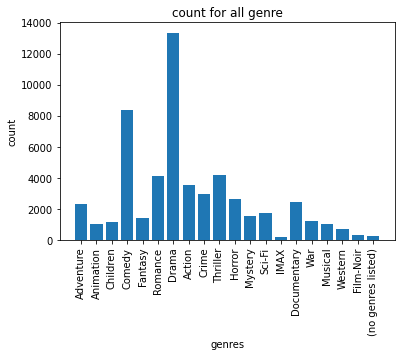

In [13]:
plt.xlabel('genres')
plt.ylabel('count')
plt.xticks(rotation=90)
plt.title('count for all genre')
plt.bar(*zip(*genre_dict.items()))
plt.plot()

In [14]:
movie = movie.join(movie.pop('genres').str.get_dummies('|'))

In [15]:
genre_dataset = {}
for row in movie.iterrows():
  genre_dataset[row[1].movieId] = row[1].values.tolist()[2:]


In [16]:
df = pd.read_csv('/path/to/NCF/Datasets/rating.csv')
df.head()

,userId,movieId,timestamp,rating
0,1,2,2/4/05 23:53,3.5
1,1,29,2/4/05 23:31,3.5
2,1,32,2/4/05 23:33,3.5
3,1,47,2/4/05 23:32,3.5
4,1,50,2/4/05 23:29,3.5


In [17]:
df.describe()

,userId,movieId,rating
count,1.048575e+06,1.048575e+06,1.048575e+06
mean,3.527086e+03,8.648988e+03,3.529272e+00
std,2.018424e+03,1.910014e+04,1.051919e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,1.813000e+03,9.030000e+02,3.000000e+00
50%,3.540000e+03,2.143000e+03,4.000000e+00
75%,5.233000e+03,4.641000e+03,4.000000e+00
max,7.120000e+03,1.306420e+05,5.000000e+00


In [18]:
df.dtypes

userId         int64
movieId        int64
timestamp     object
rating       float64
dtype: object

In [19]:
df.isnull().sum()

userId       0
movieId      0
timestamp    0
rating       0
dtype: int64

In [20]:
show_ratings_by_user = df.groupby(['userId']).size().reset_index(name='counts').sort_values(['counts'], ascending = False)
show_ratings_by_user.tail()

,userId,counts
4057,4058,20
4085,4086,20
4091,4092,20
4147,4148,20
7119,7120,20


In [21]:
show_ratings_by_user.count()

userId    7120
counts    7120
dtype: int64

There are a total of 138493 unique users with a minimum of 20 reviews/user

## Libraries installation and TPU declarations

In [19]:
import tensorflow as tf
# from tensorflow.keras.layers import Dense, Embedding, Input, Flatten, Concatenate
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from scipy.sparse import dok_matrix


Run this line when u are running TPU

In [20]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.68.145.122:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.68.145.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.68.145.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


Run this if u are running GPU

In [21]:
# gpus = tf.config.experimental.list_physical_devices("GPU")
# if gpus:
#     try:
#         # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         logical_gpus = tf.config.experimental.list_logical_devices("GPU")
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Memory growth must be set before GPUs have been initialized
#         print(e)
# strategy = tf.distribute.MirroredStrategy()

## Pre-processing

### Extract test dataset

In [22]:
all_movieIds = df['movieId'].unique()

In [23]:
df['ts'] = pd.to_datetime(df.timestamp)
df.dtypes

userId                int64
movieId               int64
timestamp            object
rating              float64
ts           datetime64[ns]
dtype: object

In [24]:
test_df= df.loc[df.groupby('userId')['ts'].idxmax()]
len(test_df)

7120

In [25]:
test_df.head()

,userId,movieId,timestamp,rating,ts
62,1,1750,2/4/05 23:56,3.5,2005-02-04 23:56:00
180,2,260,21/11/00 15:36,5.0,2000-11-21 15:36:00
237,3,24,14/12/99 12:54,3.0,1999-12-14 12:54:00
445,4,548,24/8/96 9:40,3.0,1996-08-24 09:40:00
511,5,1136,26/12/96 16:28,5.0,1996-12-26 16:28:00


In [26]:
before = len(df)

In [27]:
cond = df.index.isin(test_df.index)
df = df[~cond]

saving data for evaluation later

In [31]:
test_df.to_pickle("/path/to/NCF/Saved/NCF_test.pkl")
df.to_pickle("/path/to/NCF/Saved/NCF_df.pkl")

with open('/path/to/NCF/Saved/all_movies_id.pkl', 'wb') as handle:
  pickle.dump(all_movieIds,handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/path/to/NCF/Saved/genre_dataset.pkl', 'wb') as handle:
  pickle.dump(genre_dataset,handle, protocol=pickle.HIGHEST_PROTOCOL)


In [32]:
print("new df len: ", len(df))
print("num of data removed: ", before - len(df))

new df len:  1041455
num of data removed:  7120


### Building train and validation datasets

In [29]:
def load_rating_file_as_matrix(df):
  # Get number of users and items
  num_users, num_items = 0, 0
  
  for row in df.iterrows():
    user, item = int(row[1].userId), int(row[1].movieId)
    num_users = max(num_users, user)
    num_items = max(num_items, item)
  mat = dok_matrix((num_users+1, num_items+1), dtype=np.float64)
  for row in df.iterrows():
      user, item, rating = int(row[1].userId), int(row[1].movieId), float(row[1].rating)
      if (rating > 0):
          mat[user, item] = 1.0
  return mat

In [30]:
def get_train_instances(train, num_negatives):
  user_input, item_input, labels = [],[],[]
  num_users = train.shape[0]
  num_items = train.shape[1]
  for (u, i) in train.keys():
      # positive instance
      user_input.append(u)
      item_input.append(i)
      labels.append(1)
      # negative instances
      for t in range(num_negatives):
          j = np.random.randint(num_items)
          while train[u, j] == 1.0:
            j = np.random.randint(num_items)
          user_input.append(u)
          item_input.append(j)
          labels.append(0)
          
  return user_input, item_input, labels

In [31]:
similarity_matrix = load_rating_file_as_matrix(df)

In [32]:
similarity_matrix.shape

(7121, 130643)

In [33]:
similarity_matrix.shape

(7121, 130643)

In [34]:
NUM_NEG = 4
user_data, item_data, labels = get_train_instances(similarity_matrix, NUM_NEG)

In [35]:
valid_df = pd.DataFrame()
valid_df['userId'] = user_data
valid_df['movieId'] = item_data
x_cols = valid_df.columns[:]
x_labels = valid_df[x_cols].values

In [36]:
X_train, X_test, y_train, y_test = train_test_split(x_labels, labels, test_size=0.20, random_state=42)

In [37]:
X_train_user = []
X_train_movie = []
for x in X_train:
  X_train_user.append(x[0])
  X_train_movie.append(x[1])

X_test_user = []
X_test_movie = []
for x in X_test:
  X_test_user.append(x[0])
  X_test_movie.append(x[1])

### Declare and initialize Class Weights for Training of Deep Learning Model

In [38]:
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

{0: 0.6250326333345536, 1: 2.499478002923184}


## Model

Arguments declarations

In [39]:
user_size = len(X_train_user)
item_size = len(X_train_movie)
topK = 10
epochs = 20
BATCH_SIZE = 256 * strategy.num_replicas_in_sync #TPU
# BATCH_SIZE = 8 #GPU
LR = 0.001

assert len(X_train_user) == len(X_train_movie)
assert len(X_test_user) == len(X_test_movie)

steps_per_epoch = len(X_train_user) // BATCH_SIZE
validation_steps= len(X_test_user) // BATCH_SIZE


Converting datasets into tfdata for TPU

In [40]:
#TPU
AUTO = tf.data.experimental.AUTOTUNE
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices(({"user_input":X_train_user, "item_input":X_train_movie}, y_train))
    .batch(BATCH_SIZE)
    .repeat()
    .cache()
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices(({"user_input":X_test_user, "item_input":X_test_movie}, y_test))
    .batch(BATCH_SIZE)
    .repeat()
    .cache()
    .prefetch(AUTO)
)

Building the model

In [41]:
with strategy.scope():
  #parameters
  GMF_DIM = 8
  MLP_LAYERS = [64,32,16,8]
  NUM_LAYERS = len(MLP_LAYERS)
  REGULATORS = [0,0,0,0]

  assert len(REGULATORS) == NUM_LAYERS

  user_input = Input(shape=(1,), dtype='int32', name='user_input')
  item_input = Input(shape=(1,), dtype='int32', name='item_input')
  

  #embedding layer
  #GMF
  gmf_user_embedding = Embedding(input_dim=user_size, output_dim=GMF_DIM, name='gmf_user_embedding',  input_length=1)
  gmf_item_embedding = Embedding(input_dim=item_size, output_dim=GMF_DIM, name='gmf_item_embedding', input_length=1)
  gmf_user_embedding = Flatten()(gmf_user_embedding(user_input))
  gmf_item_embedding = Flatten()(gmf_item_embedding(item_input))
  gmf_vector = Multiply()([gmf_user_embedding, gmf_item_embedding])

  #MLP
  mlp_user_embedding = Embedding(input_dim=user_size, output_dim=int(MLP_LAYERS[0]/2), name='mlp_user_embedding', input_length=1)
  mlp_item_embedding = Embedding(input_dim=item_size, output_dim=int(MLP_LAYERS[0]/2), name='mlp_item_embedding', input_length=1)
  mlp_user_embedding = Flatten()(mlp_user_embedding(user_input))
  mlp_item_embedding = Flatten()(mlp_item_embedding(item_input))

  mlp_vector = Concatenate()([mlp_user_embedding, mlp_item_embedding])
  # mlp_vector = Dropout(0.3)(mlp_vector)

  for i in range(1, NUM_LAYERS):
    layer = Dense(MLP_LAYERS[i], activation='relu', name="mlp_layer%d" %i)
    mlp_vector = layer(mlp_vector)
    # mlp_vector = Dropout(0.1)(mlp_vector)

  #concate both models
  predict_vector = Concatenate()([mlp_vector, gmf_vector])

  #final prediction
  prediction = Dense(1, kernel_initializer="lecun_uniform", activation='relu')(predict_vector)

  model = Model(inputs=[user_input,item_input], outputs=prediction)

In [42]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
mlp_user_embedding (Embedding)  (None, 1, 32)        133306240   user_input[0][0]                 
__________________________________________________________________________________________________
mlp_item_embedding (Embedding)  (None, 1, 32)        133306240   item_input[0][0]                 
______________________________________________________________________________________________

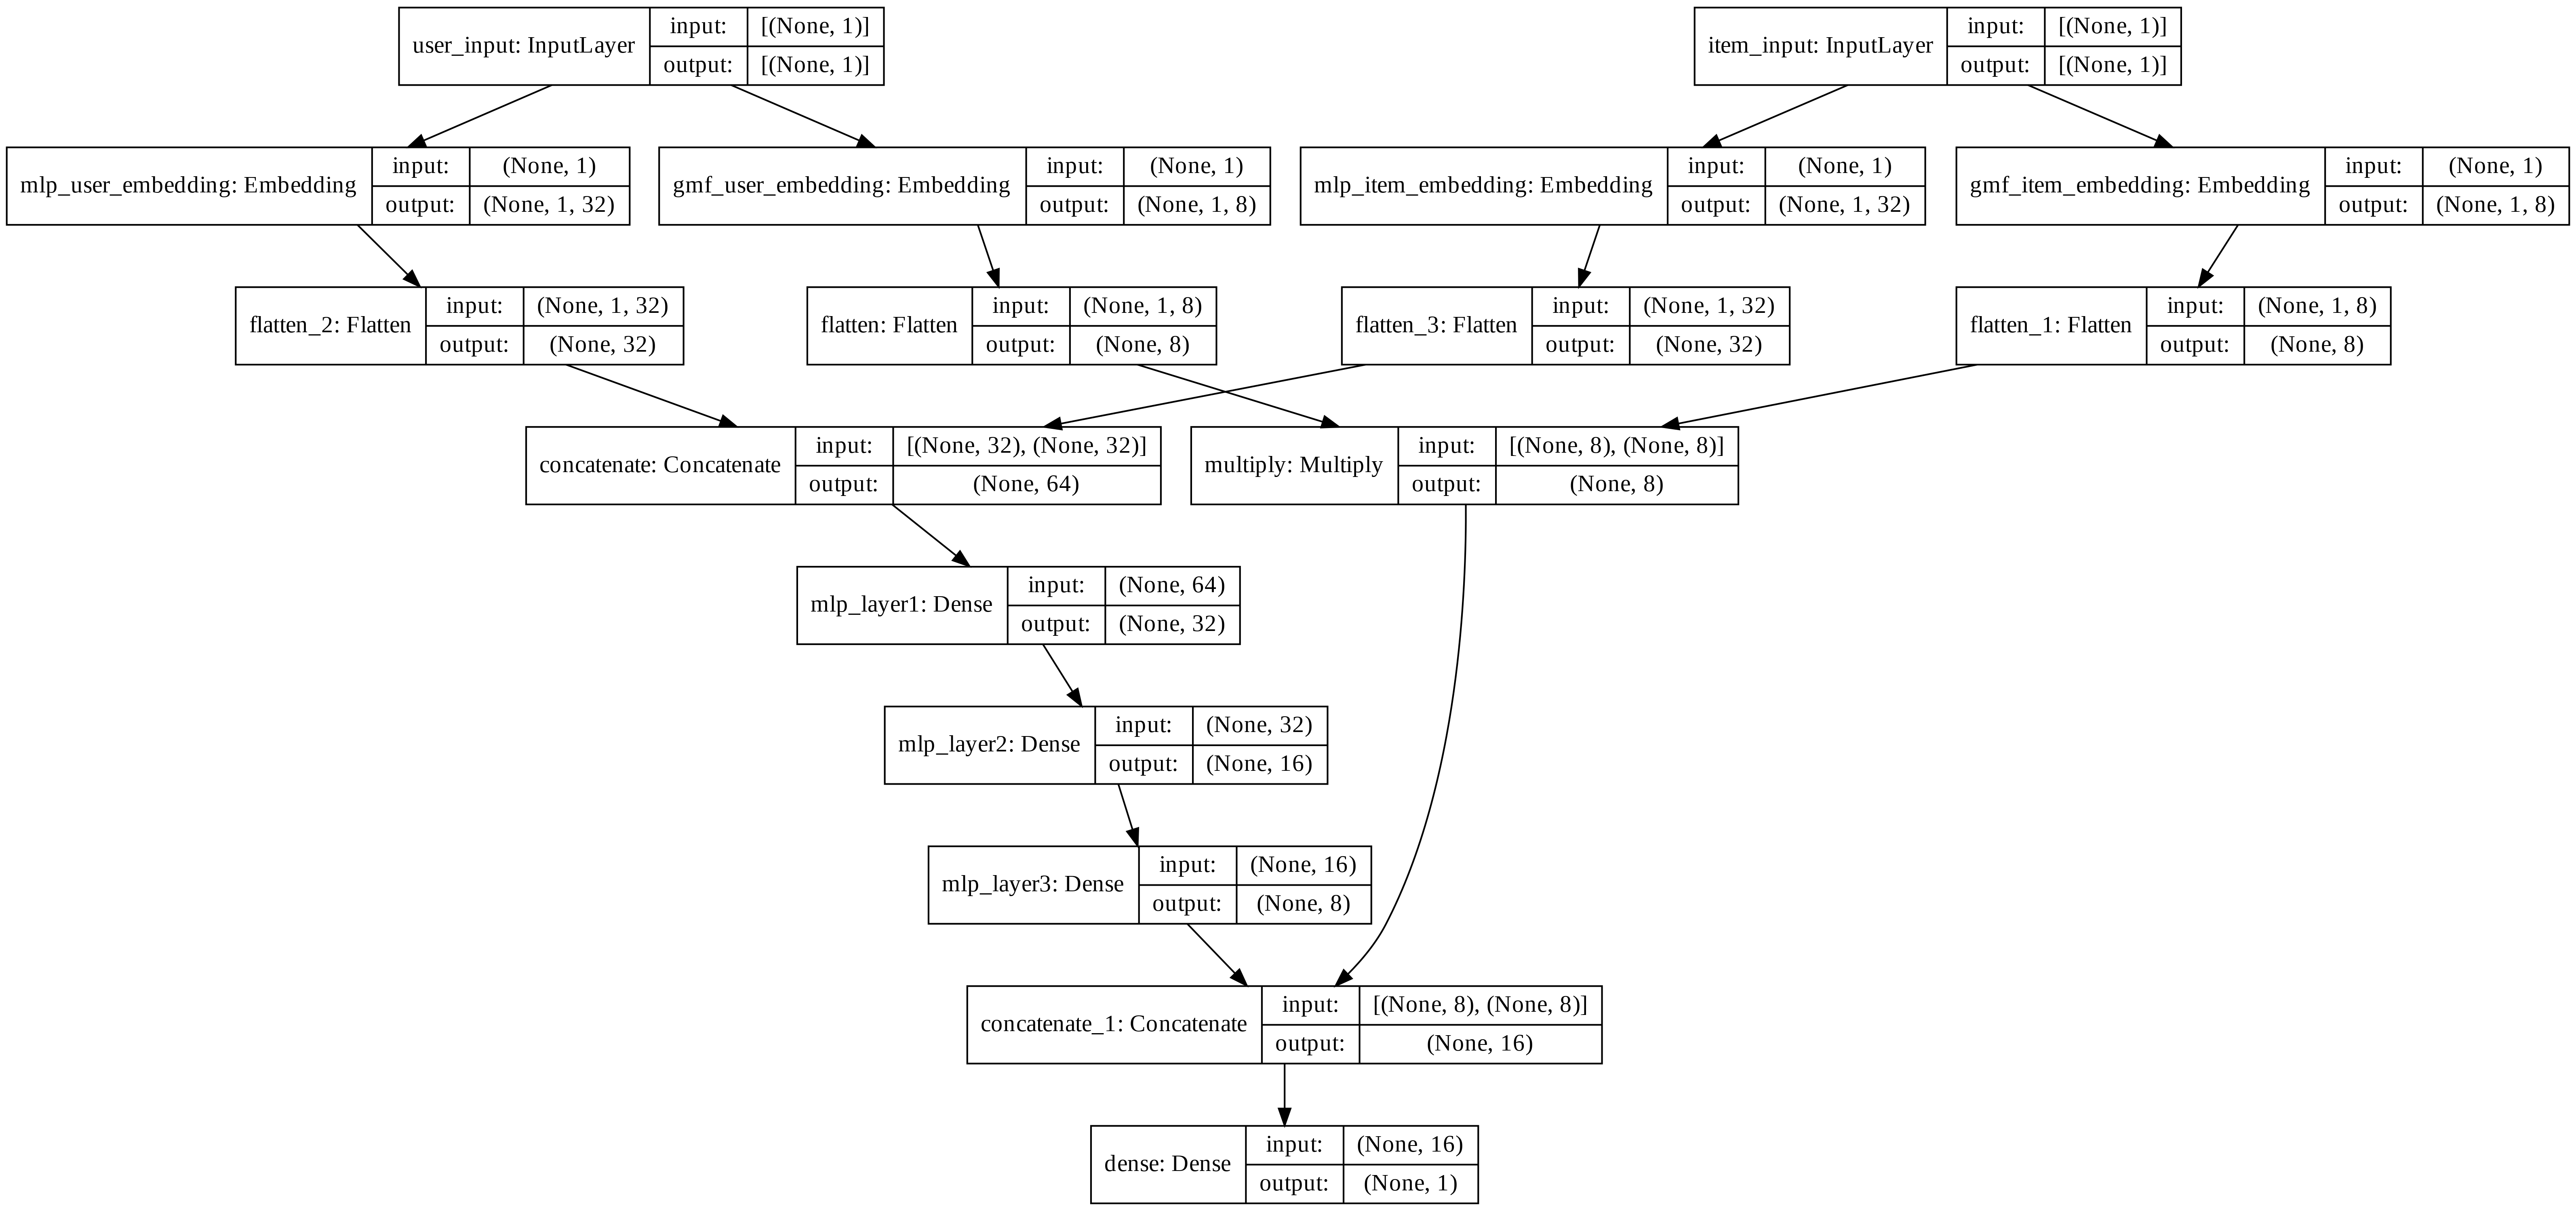

In [43]:
tf.keras.utils.plot_model(
    model,
    to_file="ensemble_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=300,
)

In [44]:
with strategy.scope():
  model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=LR), 
    metrics=['mse', "acc"]
  )

Learning rate scheduler

In [45]:
import math
WARMUP = 5

def get_cosine_schedule_with_warmup(lr, num_warmup_steps, num_training_steps, num_cycles=0.5):
    """
    Modified the get_cosine_schedule_with_warmup from huggingface for tensorflow
    (https://huggingface.co/transformers/_modules/transformers/optimization.html#get_cosine_schedule_with_warmup)

    Create a schedule with a learning rate that decreases following the
    values of the cosine function between 0 and `pi * cycles` after a warmup
    period during which it increases linearly between 0 and 1.
    """

    def lrfn(epoch):
        if epoch < num_warmup_steps:
            return float(epoch) / float(max(1, num_warmup_steps)) * lr
        progress = float(epoch - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

lr_schedule= get_cosine_schedule_with_warmup(lr=LR, num_warmup_steps=WARMUP, num_training_steps=epochs)

Training the model

In [46]:
callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# mc = ModelCheckpoint('GMF.h5', period=1)
with strategy.scope():
  ckpt = tf.keras.callbacks.ModelCheckpoint('/path/to/NCF/Saved/ckpt.h5',
                                              monitor='val_loss', 
                                              verbose=0, 
                                              save_best_only=True,
                                              save_weights_only=True, 
                                              mode='auto', 
                                              save_freq='epoch')
  # tpu
  hist = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    class_weight=d_class_weights,
    # batch_size=batch_size,
    shuffle=True,
    # validation_split=0.2,
    validation_data=valid_dataset,
    validation_steps=validation_steps,
    callbacks=[lr_schedule, callback]
  )

  # # GPU
  # hist = model.fit(
  #   [np.array(train_user_data), np.array(train_item_data)],
  #   np.array(train_labels),
  #   steps_per_epoch=steps_per_epoch,
  #   epochs=epochs,
  #   # batch_size=batch_size,
  #   shuffle=True,
  #   # validation_split=0.2,
  #   validation_data=([np.array(test_user_data), np.array(test_item_data)], np.array(test_labels)),
  #   validation_steps=validation_steps,
  #   callbacks=[lr_schedule, callback]
  # )


Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 133306240 elements. This may consume a large amount of memory.
  num_elements)


2034/2034 [==============================] - 218s 103ms/step - loss: 6.8739 - mse: 0.1999 - acc: 0.8000 - val_loss: 2.7492 - val_mse: 0.1997 - val_acc: 0.8002
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0002.
2034/2034 [==============================] - 214s 103ms/step - loss: 2.1318 - mse: 0.1905 - acc: 0.7999 - val_loss: 0.5334 - val_mse: 0.1687 - val_acc: 0.8002
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0004.
2034/2034 [==============================] - 208s 102ms/step - loss: 0.8929 - mse: 0.1350 - acc: 0.8155 - val_loss: 0.2186 - val_mse: 0.0489 - val_acc: 0.9413
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0006.
2034/2034 [==============================] - 208s 102ms/step - loss: 0.1701 - mse: 0.0449 - acc: 0.9461 - val_loss: 0.1748 - val_mse: 0.0380 - val_acc: 0.9518
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0008.
2034/2034 [=============================

Performance

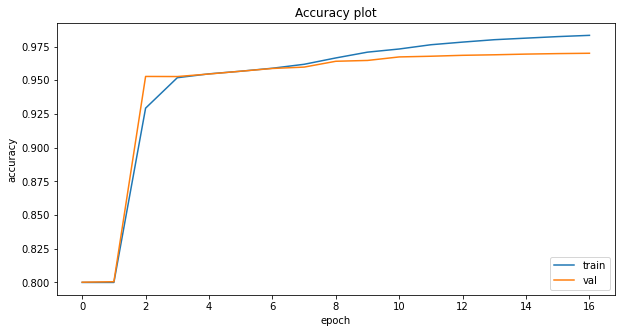

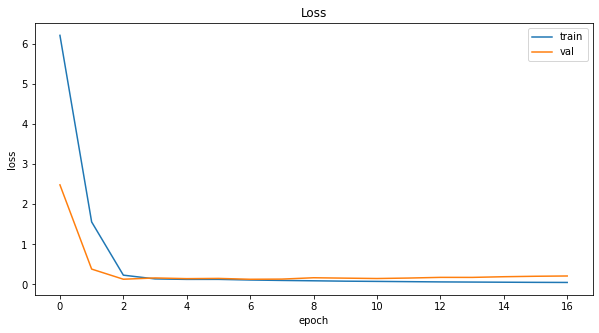

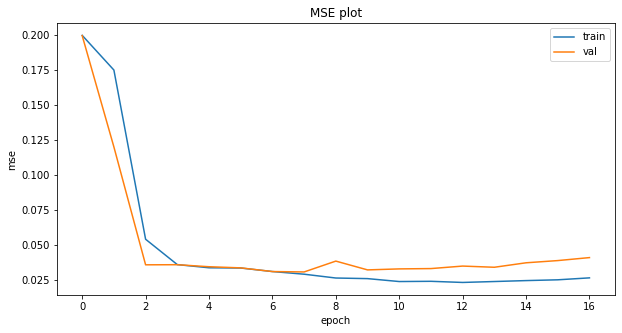

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.title('MSE plot')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()



saving the model

In [50]:
  model.save('/path/to/NCF/Saved/NCF.h5')

# Part 2
## Evaluation of model

Because of how slow TPU works from this point on,
Please ensure that your **runtime type** is set to **GPU**

Runtime > change runtime type > GPU

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Libraries installation and GPU declarations

In [3]:
import tensorflow as tf
# from tensorflow.keras.layers import Dense, Embedding, Input, Flatten, Concatenate
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from scipy.sparse import dok_matrix


Only run this if u are running TPU

In [4]:
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
strategy = tf.distribute.MirroredStrategy()

1 Physical GPUs, 1 Logical GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


loading the model, only if the model is saved

In [5]:
with strategy.scope():
  model = tf.keras.models.load_model('/path/to/NCF/Saved/NCF.h5')

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

load data

In [6]:
test_df = pd.read_pickle("/path/to/NCF/Saved/NCF_test.pkl")
df = pd.read_pickle("/path/to/NCF/Saved/NCF_df.pkl")

with open('/path/to/NCF/Saved/all_movies_id.pkl', 'rb') as handle:
  all_movieIds = pickle.load(handle)

with open('/path/to/NCF/Saved/genre_dataset.pkl', 'rb') as handle:
  genre_dataset = pickle.load(handle)

In [9]:
test_df

,userId,movieId,timestamp,rating,ts
62,1,1750,2/4/05 23:56,3.5,2005-02-04 23:56:00
180,2,260,21/11/00 15:36,5.0,2000-11-21 15:36:00
237,3,24,14/12/99 12:54,3.0,1999-12-14 12:54:00
445,4,548,24/8/96 9:40,3.0,1996-08-24 09:40:00
511,5,1136,26/12/96 16:28,5.0,1996-12-26 16:28:00
...,...,...,...,...,...
1048054,7116,110,10/2/06 3:31,4.5,2006-10-02 03:31:00
1048416,7117,1377,14/8/98 16:50,3.0,1998-08-14 16:50:00
1048465,7118,39,18/11/00 16:37,4.0,2000-11-18 16:37:00
1048544,7119,474,9/6/96 15:23,5.0,1996-09-06 15:23:00


evaluate single prediction

In [ ]:
# User-item pairs for testing
test_user_item_set = set(zip(test_df['userId'], test_df['movieId']))

# Dict of all items that are interacted with by each user
user_interacted_items = df.groupby('userId')['movieId'].apply(list).to_dict()

hits = []
count = 0

for (u,i) in test_user_item_set:
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_movieIds) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]
    users = np.full(len(test_items), u, dtype = 'int32')

    # test_dataset = (
    #   tf.data.Dataset
    #   .from_tensor_slices(({"user_input":users, "item_input":test_items}))
    #   .batch(BATCH_SIZE)
    #   .prefetch(AUTO)
    # )

    # predicted_labels = np.squeeze(model.predict(test_dataset, verbose=0))

    predicted_labels = np.squeeze(model.predict([users, np.array(test_items)], 
                                 batch_size=256, verbose=0))
    
    # predicted_labels = np.squeeze(model(torch.tensor([u]*100), 
    #                                     torch.tensor(test_items)).detach().numpy())
    
    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    if i in top10_items:
      hits.append(1)
    else:
      hits.append(0)
      
    if count % 500 == 0:
      print(count)
      print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))
    count += 1
        
print("The final Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))

0
The Hit Ratio @ 10 is 1.00
500
The Hit Ratio @ 10 is 0.73
1000
The Hit Ratio @ 10 is 0.73
1500
The Hit Ratio @ 10 is 0.72
2000
The Hit Ratio @ 10 is 0.72
2500
The Hit Ratio @ 10 is 0.72
3000
The Hit Ratio @ 10 is 0.71
3500
The Hit Ratio @ 10 is 0.71
4000
The Hit Ratio @ 10 is 0.71
4500
The Hit Ratio @ 10 is 0.71
5000
The Hit Ratio @ 10 is 0.71
5500
The Hit Ratio @ 10 is 0.71
6000
The Hit Ratio @ 10 is 0.70
6500
The Hit Ratio @ 10 is 0.70
7000
The Hit Ratio @ 10 is 0.70
The final Hit Ratio @ 10 is 0.71
